# Proyecto UT5:
## Predicción del tipo de un pokémon a partir de su imagen

### Imports

In [243]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras as kr
from tensorflow.keras.layers import Normalization, IntegerLookup, StringLookup

import os
import shutil

### Data

Primero preparamos los pokemon con sus tipos

Podemos observar que el dataframe incluye:
* __Name__: El nombre del pokemon.
* __Type1__: El tipo principal del pokemon.
* __Type2__: El tipo secundario del pokemon. En principio no lo utilizaremos para nada.

In [244]:
dataframe = pd.read_csv("pokemon.csv")
dataframe

,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN
...,...,...,...
804,stakataka,Rock,Steel
805,blacephalon,Fire,Ghost
806,zeraora,Electric,NaN
807,meltan,Steel,NaN


Asignamos las clases al tipo 1 y comprobamos todos los tipos diferentes que hay.  

In [245]:
clases = dataframe.Type1.unique()
clases

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

Guardamos el path de la imagen del pokemon en el dataframe. (Código sacado de internet). 

In [246]:
# import the modules
images = []
# get the path or directory
folder_dir = "images"
for image in os.listdir(folder_dir):
    # check if the image end swith png or jpg or jpeg
    if (image.endswith(".png") or image.endswith(".jpg") or image.endswith(".jpeg")):
        # display
        images.append(image)


Como las imágenes no están todas en el mismo formato, hay que tener cuidado y estar pendiente de si se guardan en un formato o no, por eso mismo vamos a guardarnos también su formato.

In [247]:
paths = []
format = []
for d in dataframe.Name:
    for i in images:
        if (d + ".png" == i or d + ".jpg" == i):
            paths.append("images/"+i)
            if (d + ".png" == i):
                format.append(".png")
            else:
                format.append(".jpg")

Así pues ahora tenemos guardado el __Path__ de la imagen del pokemon y también el __formato__ en el que está guardado.

In [248]:
dataframe = dataframe.assign(ImgPath=paths)
dataframe = dataframe.assign(Format=format)

dataframe

,Name,Type1,Type2,ImgPath,Format
0,bulbasaur,Grass,Poison,images/bulbasaur.png,.png
1,ivysaur,Grass,Poison,images/ivysaur.png,.png
2,venusaur,Grass,Poison,images/venusaur.png,.png
3,charmander,Fire,NaN,images/charmander.png,.png
4,charmeleon,Fire,NaN,images/charmeleon.png,.png
...,...,...,...,...,...
804,stakataka,Rock,Steel,images/stakataka.jpg,.jpg
805,blacephalon,Fire,Ghost,images/blacephalon.jpg,.jpg
806,zeraora,Electric,NaN,images/zeraora.jpg,.jpg
807,meltan,Steel,NaN,images/meltan.jpg,.jpg


Creamos el directorio organizado y copiamos las imagenes según su clase.  

In [249]:
os.mkdir("imageset")
for clase in clases:
    # if (clase == "Grass" or clase == "Water" or clase == "Fire"):
        os.mkdir("imageset/" + clase)

for (path, type, name, format) in zip(dataframe.ImgPath, dataframe.Type1, dataframe.Name, dataframe.Format):
    # if (type == "Grass" or type == "Water" or type == "Fire"):
        shutil.copyfile(path, "imageset/" + type + "/" + name + format)

FileExistsError: [WinError 183] No se puede crear un archivo que ya existe: 'imageset'

Finalmente cargamos las imagenes ya organizadas por tipos

In [ ]:
pokemons_train = tf.keras.utils.image_dataset_from_directory(directory="imageset", subset="training", validation_split=0.2, seed=413)
pokemons_val = tf.keras.utils.image_dataset_from_directory(directory="imageset", subset="validation", validation_split=0.2, seed=413)

Found 809 files belonging to 18 classes.
Using 648 files for training.
Found 809 files belonging to 18 classes.
Using 161 files for validation.


In [ ]:
cls = pokemons_train.class_names
cls

['Bug',
 'Dark',
 'Dragon',
 'Electric',
 'Fairy',
 'Fighting',
 'Fire',
 'Flying',
 'Ghost',
 'Grass',
 'Ground',
 'Ice',
 'Normal',
 'Poison',
 'Psychic',
 'Rock',
 'Steel',
 'Water']

### Modelo

Ajustamos el numero de clases según la cantidad de clases que detecte en los datos.

In [ ]:
num_clases = len(pokemons_train.class_names)

Entrenamiento del modelo, con varias capas convolucionales para detectar imágenes.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 5, activation="relu"),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(32),

    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(num_clases)
])

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [ ]:
model.fit(
    pokemons_train,
    validation_data = pokemons_val,
    epochs=3
)

Epoch 1/3
21/21 [==============================] - 36s 2s/step - loss: 2.8389 - accuracy: 0.1358 - val_loss: 2.8640 - val_accuracy: 0.0994
Epoch 2/3
21/21 [==============================] - 37s 2s/step - loss: 2.7988 - accuracy: 0.1806 - val_loss: 2.8484 - val_accuracy: 0.1056
Epoch 3/3
21/21 [==============================] - 36s 2s/step - loss: 2.6820 - accuracy: 0.2346 - val_loss: 2.8532 - val_accuracy: 0.0870


Hacemos una lista de predicciones.

In [273]:
predictions = model.predict(pokemons_train)

Elegimos un número al azar y mostramos su predicción.

Luego mostramos el tipo que más posibilidades tiene de ser y mostramos la imagen para poder comprobarlo.

Hay un 34.0 por ciento de posibilidades de que este pokémon pertenezca al tipo Water


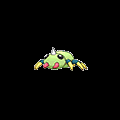

In [301]:
num = 413
print("Hay un %.1f por ciento de posibilidades de que este pokémon pertenezca al tipo" % (predictions[num].max() * 100), cls[(predictions[num].argmax())])

tf.keras.utils.load_img(pokemons_train.file_paths[num])

In [302]:
print("El resto de opciones son:")
c = 0
for p in predictions[num]:
    print(cls[c], ": ", p*100)
    c += 1

El resto de opciones son:
Bug :  6.882584095001221
Dark :  -7.080309092998505
Dragon :  -4.1304051876068115
Electric :  5.126071721315384
Fairy :  -10.51969975233078
Fighting :  -24.808822572231293
Fire :  -1.3931021094322205
Flying :  -32.34458267688751
Ghost :  21.09687179327011
Grass :  10.410396754741669
Ground :  4.8664391040802
Ice :  0.6973378360271454
Normal :  33.96526277065277
Poison :  -30.180823802947998
Psychic :  -0.4184652119874954
Rock :  -4.949664324522018
Steel :  -9.549427032470703
Water :  34.007418155670166
